In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime
from pandas_datareader.data import DataReader

In [11]:
tech_list = ['INUV', 'BIOL']
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

In [13]:
for stock in tech_list:
    globals()[stock] = DataReader(stock, 'yahoo', start, end)

In [14]:
company_list = [INUV, BIOL]
company_name = ['INUVO', 'BIOLASE']
for company, com_name in zip(company_list, company_name):
    company['company_name'] = com_name
df = pd.concat(company_list, axis=0)

In [15]:
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']

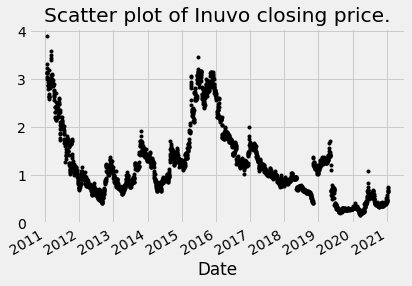

In [17]:
df_close_inu = INUV['Close']
df_close_inu.plot(style='k.')
plt.title('Scatter plot of Inuvo closing price.')
plt.show()

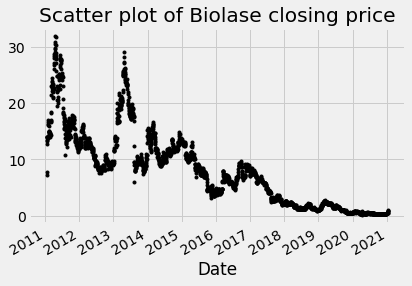

In [18]:
df_close_bio = BIOL['Close']
df_close_bio.plot(style='k.')
plt.title('Scatter plot of Biolase closing price')
plt.show()

## Augmented Dickey-Fuller Test
This test is used to determine the existence of a unit root in the series, and therefore help us if the series is stationary or not.<br />
Null hypothesis: The series has a unit root (value of 1). <br />
Alternate hypothesis: The series has no unit root. <br />
If we fail to reject the null hypothesis, we can say the series is non-stationary, which means that the series can be linear.  If both the mean and standard deviation are flat lines, the series is stationary.

In [19]:
#Test for stationarity
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std. Dev.')
    plt.legend(loc='best')
    plt.title("Rolling mean and standard deviation")
    plt.show(block=False)
    print("Results of Dickey-Fuller Test")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations'])
    for key, values in adft[4].items():
        output['critical value (%s)'%key] = values
    print(output)

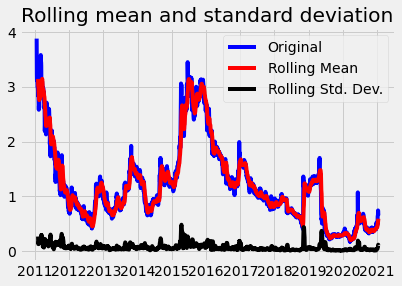

Results of Dickey-Fuller Test
Test Statistics             -3.178764
p-value                      0.021247
No. of lags used             1.000000
Number of observations    2515.000000
critical value (1%)         -3.432953
critical value (5%)         -2.862690
critical value (10%)        -2.567382
dtype: float64


In [20]:
test_stationarity(df_close_inu)

In the case of the Inuvo stock, we reject the null hypothesis (p < 0.05), therefore the series has a unit root and is stationary.

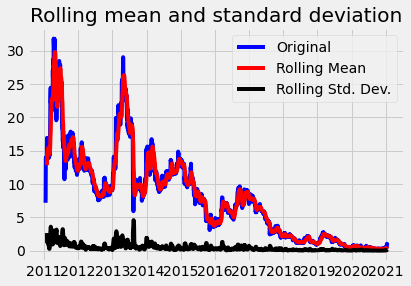

Results of Dickey-Fuller Test
Test Statistics             -1.933863
p-value                      0.316302
No. of lags used            26.000000
Number of observations    2490.000000
critical value (1%)         -3.432979
critical value (5%)         -2.862701
critical value (10%)        -2.567388
dtype: float64


In [21]:
test_stationarity(df_close_bio)

In the case of the Biolase stock, we cannot reject the null hypothesis (p > 0.05) and since the test statistics are greater than the critical values, the data is non-stationary.

<Figure size 432x288 with 0 Axes>

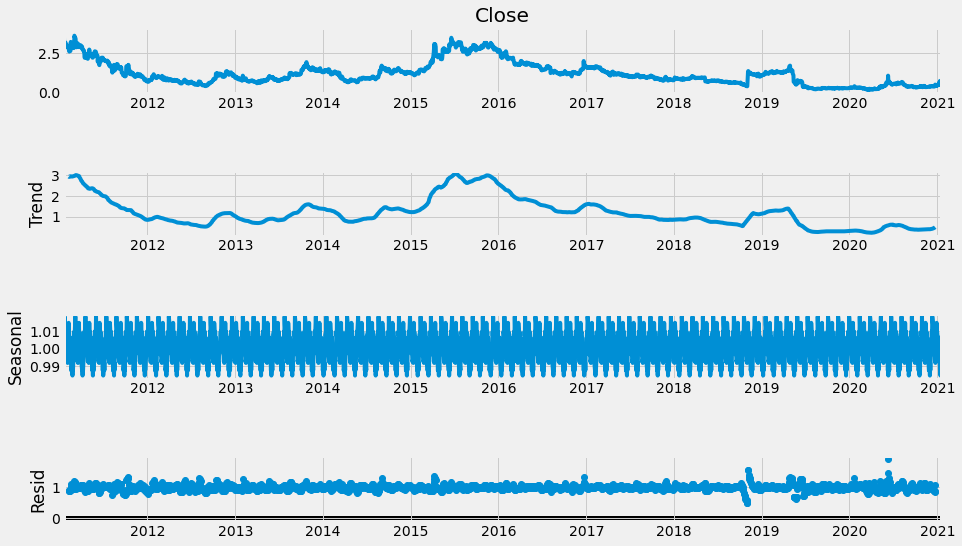

In [25]:
result_inu = seasonal_decompose(df_close_inu, model='multiplicative', freq=30)
fig = plt.figure()
fig = result_inu.plot()
fig.set_size_inches(16, 9)

<Figure size 432x288 with 0 Axes>

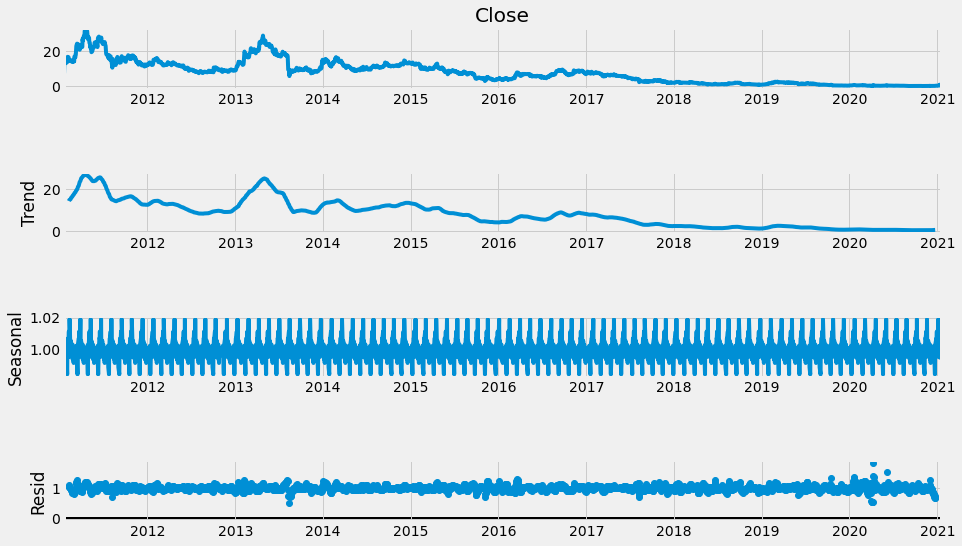

In [24]:
result_bio = seasonal_decompose(df_close_bio, model='multiplicative', freq=30)
fig = plt.figure()
fig = result_bio.plot()
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


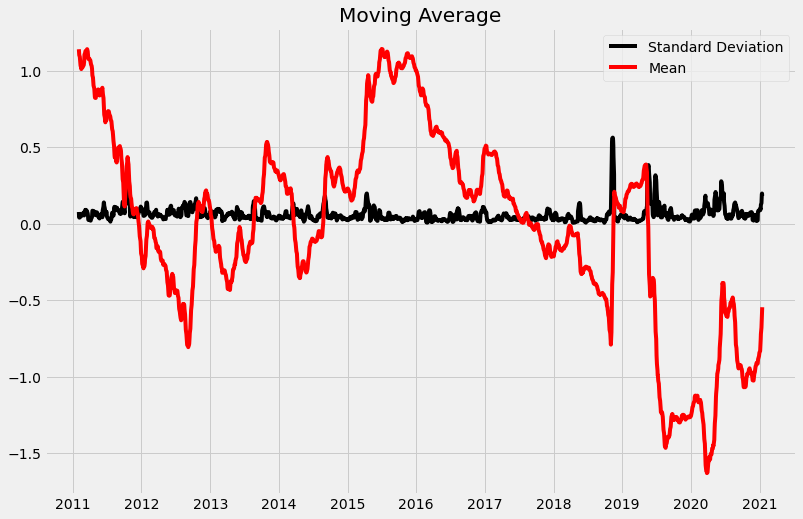

In [26]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
df_inu_log = np.log(df_close_inu)
moving_avg = df_inu_log.rolling(12).mean()
std_dev = df_inu_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.plot(moving_avg, color='red', label='Mean')
plt.legend()
plt.show()

No handles with labels found to put in legend.


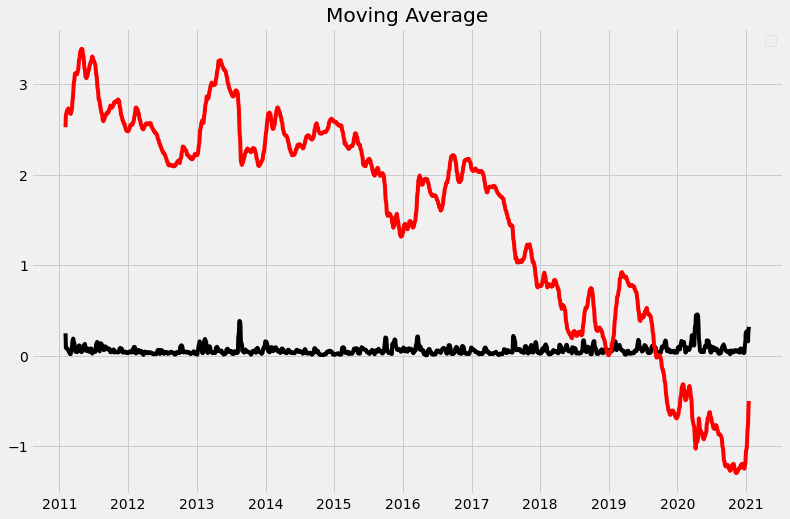

In [27]:
df_log_bio = np.log(df_close_bio)
moving_avg = df_log_bio.rolling(12).mean()
std_dev = df_log_bio.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color='black', label="Standard Deviation")
plt.plot(moving_avg, color='red', label='Mean')
plt.show()

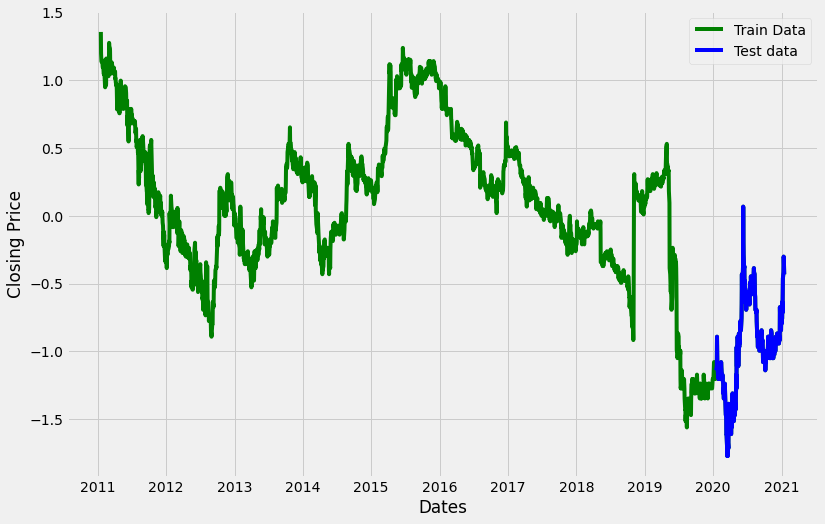

In [31]:
#Split the data into training and test sets for each stock
train_data_inu, test_data_inu = df_inu_log[3:int(len(df_inu_log)*0.9)], df_inu_log[int(len(df_inu_log)*0.9):]
plt.figure(figsize=(12, 8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.plot(df_inu_log, 'green', label='Train Data')
plt.plot(test_data_inu, 'blue', label='Test data')
plt.legend()

In [33]:
model_inu_modelARIMA = auto_arima(train_data_inu, start_p = 0, start_q = 0,
                                 test='adf', max_p=3, max_q=3, m=1, d = None,
                                 seasonal=False, start_P = 0, D = 0, trace=True,
                                 error_action='ignore', suppress_warnings=True,
                                 stepwise=True)
print(model_inu_modelARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6511.073, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6521.121, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6521.622, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6512.354, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6521.099, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6520.458, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6520.398, Time=0.84 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6522.773, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6522.176, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6521.567, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6522.290, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6521.283, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.270 seconds
                               SARIMAX Results                              

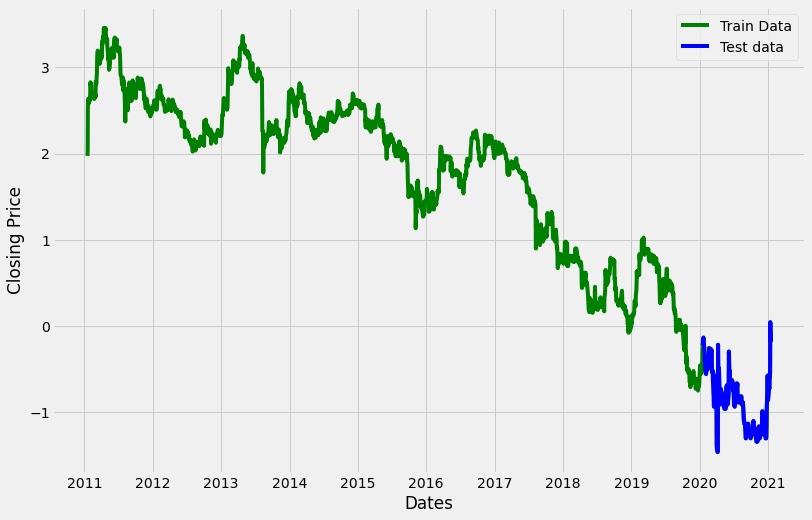

In [35]:
train_data_bio, test_data_bio = df_log_bio[3:int(len(df_log_bio)*0.9)], df_log_bio[int(len(df_log_bio)*0.9):]
plt.figure(figsize=(12, 8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.plot(df_log_bio, 'green', label='Train Data')
plt.plot(test_data_bio, 'blue', label='Test data')
plt.legend()

In [36]:
model_bio_modelARIMA = auto_arima(train_data_bio, start_p = 0, start_q = 0,
                                 test='adf', max_p=3, max_q=3, m=1, d = None,
                                 seasonal=False, start_P = 0, D = 0, trace=True,
                                 error_action='ignore', suppress_warnings=True,
                                 stepwise=True)
print(model_bio_modelARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6912.892, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6919.245, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6919.760, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6913.532, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6918.722, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6919.303, Time=0.88 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6917.804, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6920.194, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6919.082, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6919.648, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6919.704, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6918.175, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.180 seconds
                               SARIMAX Results                              

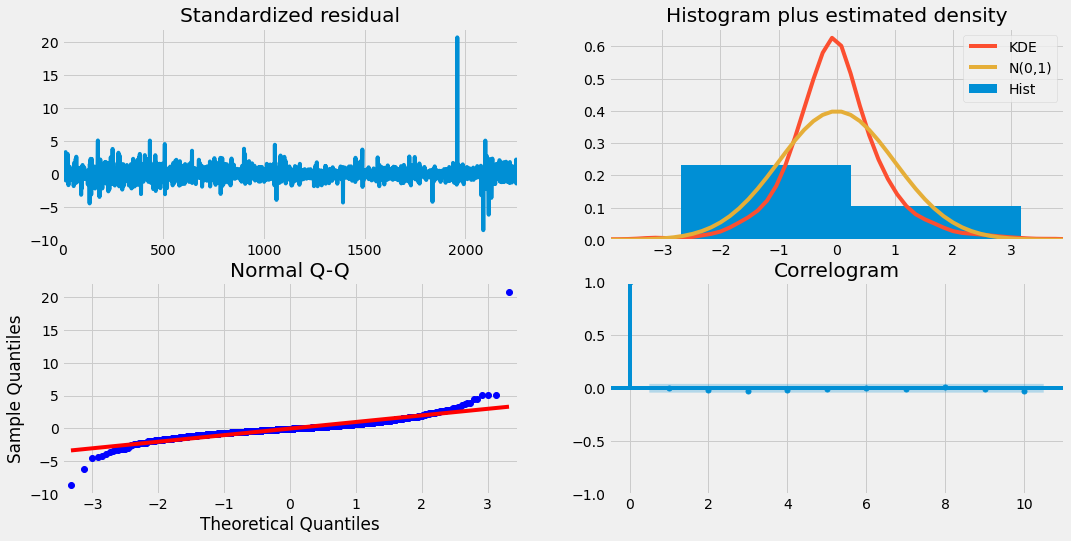

In [39]:
model_inu_modelARIMA.plot_diagnostics(figsize=(16, 8))
plt.show()

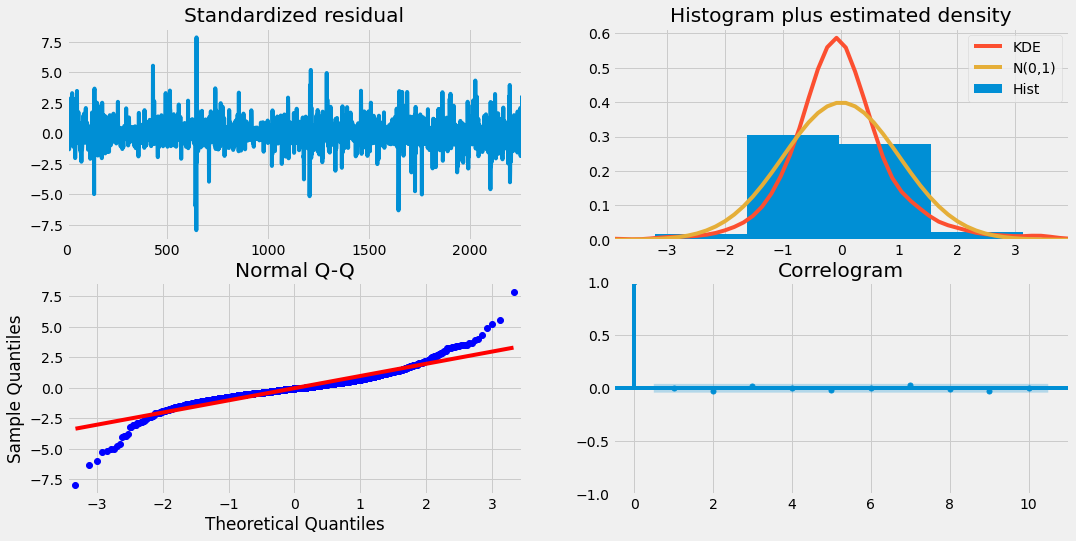

In [40]:
model_bio_modelARIMA.plot_diagnostics(figsize=(16, 8))
plt.show()

In [45]:
model_inu = ARIMA(train_data_inu, order=(0, 1, 1))
fitted_inu = model_inu.fit(disp=-1)
print(fitted_inu.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2261
Model:                 ARIMA(0, 1, 1)   Log Likelihood                3263.811
Method:                       css-mle   S.D. of innovations              0.057
Date:                Mon, 18 Jan 2021   AIC                          -6521.622
Time:                        16:42:55   BIC                          -6504.451
Sample:                             1   HQIC                         -6515.356
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0010      0.001     -0.920      0.358      -0.003       0.001
ma.L1.D.Close    -0.0760      0.021     -3.551      0.000      -0.118      -0.034
                                    Root

In [46]:
model_bio = ARIMA(train_data_bio, order=(0, 1, 1))
fitted_bio = model_bio.fit(disp=-1)
print(fitted_bio.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2261
Model:                 ARIMA(0, 1, 1)   Log Likelihood                3462.880
Method:                       css-mle   S.D. of innovations              0.052
Date:                Mon, 18 Jan 2021   AIC                          -6919.760
Time:                        16:42:58   BIC                          -6902.590
Sample:                             1   HQIC                         -6913.495
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0013      0.001     -1.252      0.210      -0.003       0.001
ma.L1.D.Close    -0.0644      0.022     -2.990      0.003      -0.107      -0.022
                                    Root

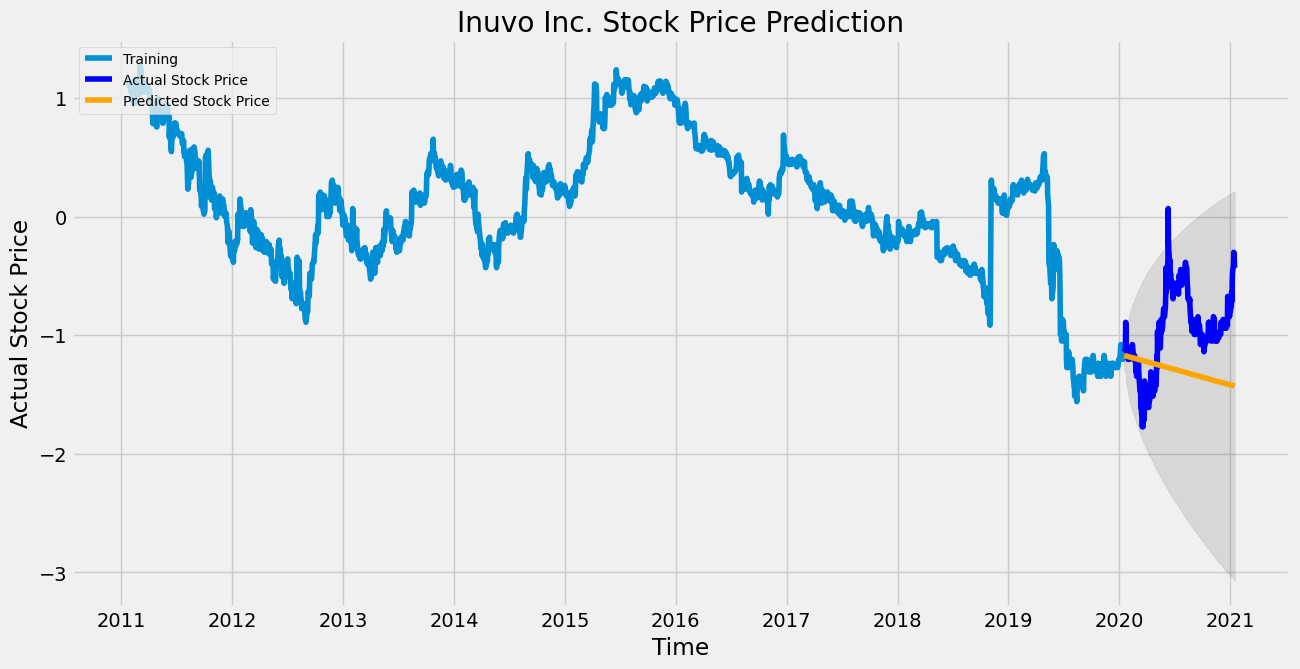

In [52]:
#Forecasting
fc, se, conf = fitted_inu.forecast(252, alpha=0.05)
fc_series = pd.Series(fc, index=test_data_inu.index)
lower_series = pd.Series(conf[:, 0], index=test_data_inu.index)
upper_series = pd.Series(conf[:, 1], index=test_data_inu.index)
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(train_data_inu, label='Training')
plt.plot(test_data_inu, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.10)
plt.title('Inuvo Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [53]:
# Performance of model for INUV
mse = mean_squared_error(test_data_inu, fc)
print('MSE: ' + str(mse))
mae = mean_absolute_error(test_data_inu, fc)
print('MAE: ' + str(mae))
rmse = math.sqrt(mean_squared_error(test_data_inu, fc))
print('RMSE: ' + str(rmse))
mape = np.mean(np.abs(fc-test_data_inu)/np.abs(test_data_inu))
print("MAPE: " + str(mape))

MSE: 0.26550236324385773
MAE: 0.44252390685479165
RMSE: 0.5152692143373769
MAPE: 0.735618036322378


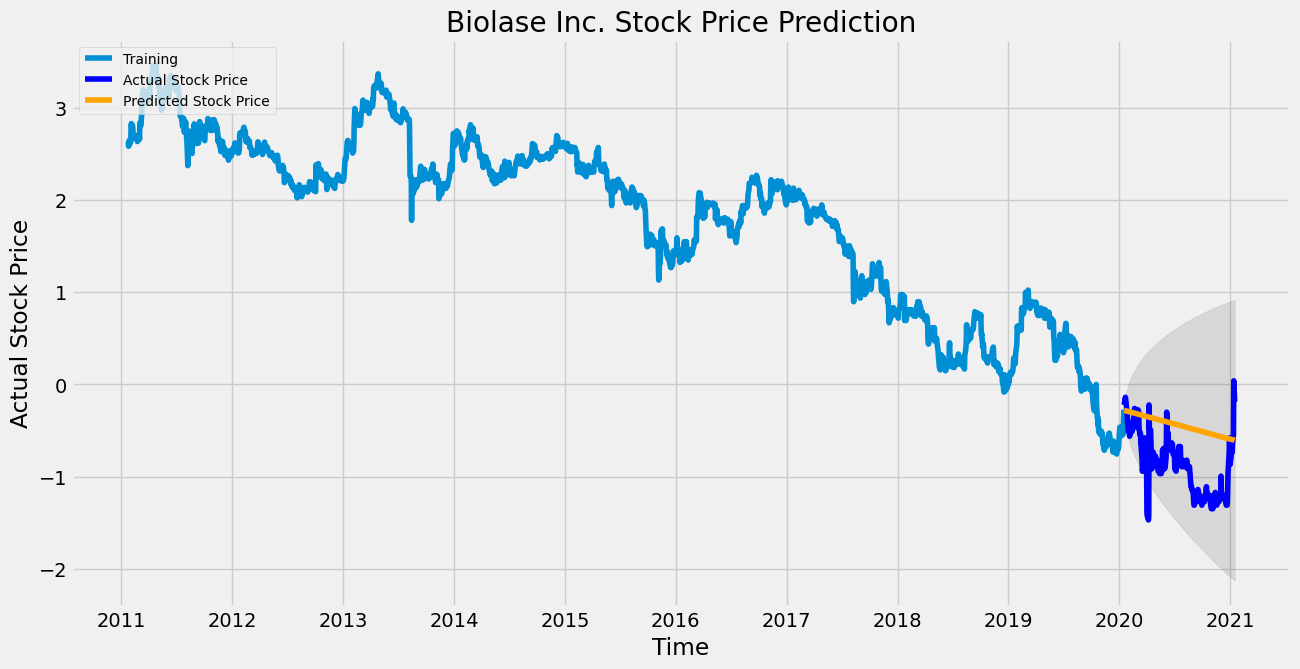

In [50]:
fc, se, conf = fitted_bio.forecast(252, alpha=0.05)
fc_series = pd.Series(fc, index=test_data_bio.index)
lower_series = pd.Series(conf[:, 0], index=test_data_bio.index)
upper_series = pd.Series(conf[:, 1], index=test_data_bio.index)
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(train_data_bio, label='Training')
plt.plot(test_data_bio, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.10)
plt.title('Biolase Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [54]:
# Performance of model for BIOL
mse = mean_squared_error(test_data_bio, fc)
print('MSE: ' + str(mse))
mae = mean_absolute_error(test_data_bio, fc)
print('MAE: ' + str(mae))
rmse = math.sqrt(mean_squared_error(test_data_bio, fc))
print('RMSE: ' + str(rmse))
mape = np.mean(np.abs(fc - test_data_bio)/np.abs(test_data_bio))
print("MAPE:" + str(mape))

MSE: 0.2629962957164555
MAE: 0.4294624842922677
RMSE: 0.5128316446129816
MAPE:1.038740362484109


## Conclusions
1) While the price of these stocks are attractive, it would not be worthwhile to invest in them. <br />
2) While the ARIMA predicts a modest downward turn for these stocks, outside forces may impact this prediction. <br />
3) Because the error rate is high for both of these stocks, ARIMA may not be the best model for this prediction.
